In [1]:
import numpy as np
import sciope

from sciope.utilities.priors.uniform_prior import UniformPrior
from sciope.utilities.summarystats.identity import Identity
from sciope.utilities.distancefunctions.euclidean import EuclideanDistance
from sciope.utilities.perturbationkernels.multivariate_normal import MultivariateNormalKernel
from sciope.utilities.epsilonselectors.relative_epsilon_selector import RelativeEpsilonSelector
from sciope.utilities.epsilonselectors.absolute_epsilon_selector import AbsoluteEpsilonSelector

from sciope.inference.abc_inference import ABC
from sciope.inference.smc_abc import SMCABC
from sciope.inference.rep_smc_abc import ReplenishmentSMCABC

import matplotlib.pyplot as plt

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [2]:
def simulator(param, n=100):
    """
    Simulate a given parameter combination.

    Parameters
    ----------
    param : vector or 1D array
        Parameters to simulate (\theta).
    n : integer
        Time series length
    """
    m = len(param)
    g = np.random.normal(0, 1, n)
    gy = np.random.normal(0, 0.3, n)
    y = np.zeros(n)
    x = np.zeros(n)
    for t in range(0, n):
        x[t] += g[t]
        for p in range(0, np.minimum(t, m)):
            x[t] += g[t - 1 - p] * param[p]
        y[t] = x[t] + gy[t]
    
    return np.reshape(y, (1,1,100))

# Data

In [3]:
#target_ts = np.load('target_ts.npy')
obs_data = np.load('target_ts.npy')

In [4]:
obs_data = np.reshape(obs_data, (1, 1, 100))

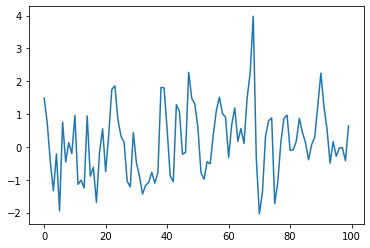

In [6]:
plt.plot(obs_data[0].T)

# Prior Distributions

true = [0.6, 0.2]

In [7]:
parameter_names = ['k1', 'k2']

lower_bounds = [-2, -1]
upper_bounds = [2, 1]

prior = UniformPrior(np.array(lower_bounds), np.array(upper_bounds))

# Summary Statistics and Distance Function

### Statistics and Euclidean Distance

In [61]:
distance_func = EuclideanDistance()

In [35]:
from sciope.utilities.summarystats import auto_tsfresh

default_fc_params = {
                     'variance':None,
                     'autocorrelation':
                         [{'lag':1},
                          {'lag':2}]}

summaries = auto_tsfresh.SummariesTSFRESH(features=default_fc_params)

In [61]:
#test
summaries.compute(simulator([0.1,0.2]))

array([[ 1.06345798, -0.10766169,  0.18812816]])

# Inference

### Using ABC-SMC
Obs. ABC-SMC require many samples, thus take a while to run. Change "max_rounds" for faster covergence (but lower accuracy) or press Ctrl-C to return current result

In [36]:
# Start abc instance, one run!
from sciope.inference.smc_abc import SMCABC

max_rounds = 6
eps_selector = RelativeEpsilonSelector(20, max_rounds)

smcabc = SMCABC(obs_data, # Observed Dataset
          simulator, # Simulator method
          prior, # Prior
          summaries_function=summaries.compute
          )
smc_abc_results = smcabc.infer(num_samples = 100, batch_size = 1000, chunk_size=1, eps_selector=eps_selector)

Determining initial population using 20
Starting epsilon = 0.7127150146313911
Starting epsilon = 0.3452572637311463
Starting epsilon = 0.17187627723859816
Starting epsilon = 0.10085629858357806
Starting epsilon = 0.05490815404597481


In [43]:
#final estimated posterior
posterior = np.array(smc_abc_results[-1]['accepted_samples'])

In [53]:
#Several runs to evaluate robustness

results = []
tot_runs = 10

for i in range(tot_runs):
    print(f'statring run{i}')

    max_rounds = 6
    eps_selector = RelativeEpsilonSelector(20, max_rounds)

    smcabc = SMCABC(obs_data, # Observed Dataset
              simulator, # Simulator method
              prior, # Prior
              summaries_function=summaries.compute
              )

    %time smc_abc_results = smcabc.infer(num_samples = 3000, batch_size = 1, chunk_size=1, eps_selector=eps_selector)

    results.append(smc_abc_results)

statring run0
Determining initial population using 20
Starting epsilon = 0.7253871151081972
Starting epsilon = 0.34903585949235433
Starting epsilon = 0.18546637673857977
Starting epsilon = 0.1052172322919937
Starting epsilon = 0.06049133273847076
CPU times: user 39min 10s, sys: 2min 45s, total: 41min 56s
Wall time: 39min 49s
statring run1
Determining initial population using 20
Starting epsilon = 0.7100442510861815
Starting epsilon = 0.3411904875278523
Starting epsilon = 0.18435838376866998
Starting epsilon = 0.10160641010440132
Starting epsilon = 0.05827375287116587
CPU times: user 43min 20s, sys: 3min 2s, total: 46min 22s
Wall time: 44min 2s
statring run2
Determining initial population using 20
Starting epsilon = 0.7420393197071374
Starting epsilon = 0.35237083019429616
Starting epsilon = 0.1844659262070908
Starting epsilon = 0.1023284205480118
Starting epsilon = 0.05875373853814394
CPU times: user 41min 4s, sys: 2min 51s, total: 43min 55s
Wall time: 41min 42s
statring run3
Determini

In [54]:
#Get posterior samples and the number of candidate trials in each round
smc_posterios = []
smc_trail_count = []

for i in results:
    run = []
    trial = []
    for j in i:
        run.append(j['accepted_samples'])
        trial.append(j['trial_count'])
    smc_posterios.append(run)
    smc_trail_count.append(trial)

In [55]:
smc_posteriors = np.array(smc_posterios)
smc_trail_count = np.array(smc_trail_count)

In [57]:
#Save data
np.save('smcabc_trails_batchsize1_samples3k', smc_trail_count)
np.save('smcabc_post_batchsize1_samples3k', smc_posteriors)

### Using Replenishment ABC-SMC
An other variant of ABC-SMC (not used in manuscript), require no "max_rounds"

In [190]:
from sciope.inference.rep_smc_abc import ReplenishmentSMCABC

repsmcabc = ReplenishmentSMCABC(obs_data,
                                simulator,
                                prior,
                                summaries_function=summaries.compute
                               )
repsmcabc.compute_fixed_mean(1)

In [191]:
%%time 
rsmc_abc_results = repsmcabc.infer(num_samples = 3000, batch_size = 1000)

posterior = np.vstack(rsmc_abc_results['accepted_samples'])

Tol : 1.4971398720570783, R : 6, p_acc : 0.541
Tol : 0.8646312366515494, R : 7, p_acc : 0.48966666666666664
Tol : 0.6333235205117045, R : 8, p_acc : 0.4225333333333333
Tol : 0.49043817313221666, R : 10, p_acc : 0.3660666666666667
Tol : 0.38392068447396593, R : 16, p_acc : 0.4917111111111111
Tol : 0.3086316163317443, R : 27, p_acc : 0.3108705882352941
Tol : 0.2535496653386165, R : 43, p_acc : 0.19616969696969697
Tol : 0.2090614291529074, R : 78, p_acc : 0.11015882352941177
Tol : 0.17221531066376342, R : 154, p_acc : 0.058244444444444446
Tol : 0.14310073513924632, R : 303, p_acc : 0.02887326507394767
CPU times: user 40min 38s, sys: 2min 54s, total: 43min 32s
Wall time: 40min 46s


## Analysis

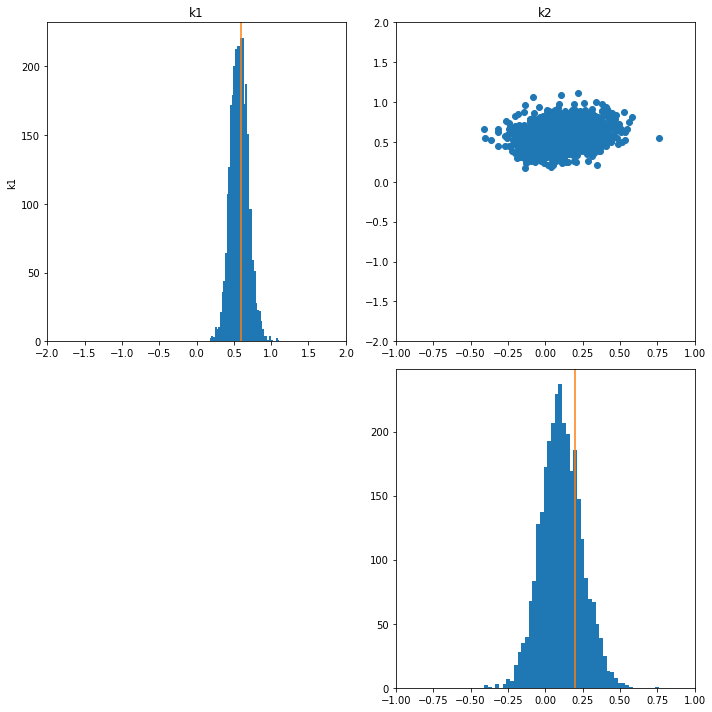

In [60]:
true_params = [0.6, 0.2]
fig, ax = plt.subplots(posterior.shape[1], posterior.shape[1], facecolor = 'w')
for i in range(posterior.shape[1]):
    for j in range(posterior.shape[1]):
        if i > j:
            ax[i,j].axis('off')
        else:
            if i == j:
                ax[i,j].hist(posterior[:,i], bins = 'auto')
                #ax[i,j].axvline(np.median(posterior[:,i]), color = 'C1')
                ax[i,j].axvline(true_params[i], color='C1')
                ax[i,j].set_xlim(lower_bounds[i], upper_bounds[i])
            else:
                ax[i,j].scatter(posterior[:,j], posterior[:,i])
                ax[i,j].set_ylim(lower_bounds[i], upper_bounds[i])
                ax[i,j].set_xlim(lower_bounds[j], upper_bounds[j])
    ax[i,0].set_ylabel(parameter_names[i])
    ax[0,i].set_title(parameter_names[i])
fig.set_size_inches(10,10)
fig.tight_layout()

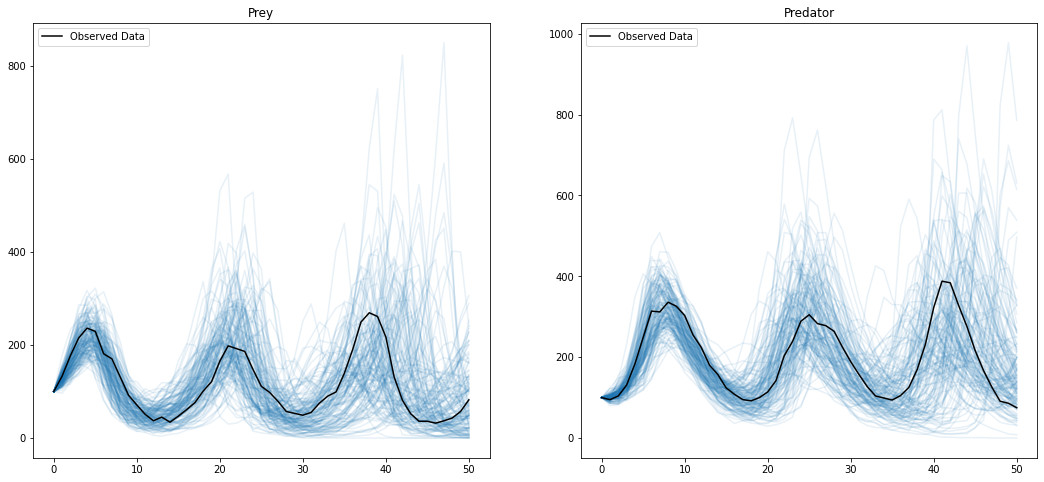

In [12]:
fig, ax = plt.subplots(1,2, facecolor = 'w', edgecolor = 'w')
for i in range(posterior.shape[0]):
    res = simulator2(posterior[i,:])
    ax[0].plot(res[0,0,:], color = 'C0', alpha = 0.1)
    ax[1].plot(res[0,1,:], color = 'C0', alpha = 0.1)
ax[0].plot(obs_data[0,0,:], color = 'black', label = 'Observed Data')
ax[1].plot(obs_data[0,1,:], color = 'black', label = 'Observed Data')
ax[0].set_title("Prey")
ax[1].set_title("Predator")
ax[0].legend()
ax[1].legend()
fig.set_size_inches(18, 8)